Now that we have the datasets refreshed with 2017 data, let's repeat last year's analysis with a more specific intent to see who in Australia has been contributing to nips

## Admin and imports

In [1]:
from bs4 import BeautifulSoup
import json
import os, sys
import pandas as pd; import numpy as np
import re
import requests
import subprocess
from datetime import  datetime, date, timedelta
import seaborn as sns

## Import dataset

In [2]:
df_auth = pd.read_json('output/authors.json')
df_paper = pd.read_json('output/papers.json')
df_pa = pd.read_json('output/paper_authors.json')
df_auth.shape, df_paper.shape, df_pa.shape

((9787, 1), (7241, 6), (20843, 2))

## filter for country specific papers and authors

### Mark all papers likely from Australian authors

In [3]:
df_paper['paper_length'] = df_paper['paper_text'].str.split().apply(len)

In [4]:
# get the first 500 words of the paper text
df_paper['paper_text_500_words'] = df_paper['paper_text'].apply(lambda x: ' '.join(x.split()[:500]))

In [5]:
# from an initial inspection of papers last year, I had noticed that authors from a particular country
# features the name of the country somewhere - either after the university or in the abstract. So my guess
# is that we can mine the first 500 words of a paper to see whether that paper by an Ozzie author. 
# obviously, there's huge chances of there being false positives, but what's the downside? I'll read an 
# additional paper from the top conference in my field?
df_paper['country_paper'] = np.where(df_paper['paper_text_500_words'].str.upper().str.contains('AUSTRALIA'),1,0)

In [6]:
df_paper['country_paper'].value_counts()

0    7077
1     164
Name: country_paper, dtype: int64

Last year, i had gotten 154 papers with the same criterion. So safe to say that ~10 papers have been submitted in 2017. This will be a good litmus test.

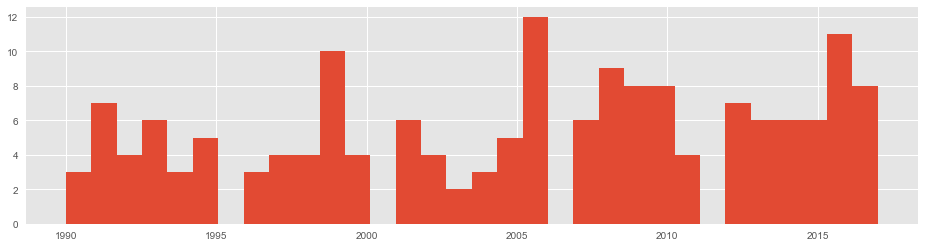

In [7]:
import matplotlib; import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot'); fig = plt.figure(figsize=(16,4));ax = fig.add_subplot(111)
df_paper.loc[df_paper.country_paper==1,'year'].hist(bins=32)

Interesting to see a fairly steady research contribution inspite of the hype machine surrounding AI over the past few years. I know that in Australia, more people have been joining AI industry as well as more roles/jobs have been opening up. Is this gap at the top AI talent not being filled by premium AI researchers in the country?

In [8]:
# get authors into the ozi dataset
df_ozi = pd.merge(left=df_paper[df_paper.country_paper == 1], right=df_pa, left_index=True, right_on='paper_id',suffixes=('_papers', '_key'))
df_ozi = pd.merge(left = df_ozi, right = df_auth, how='left',left_on='author_id', right_index=True,suffixes=('_country', '_author'))
df_ozi.drop(['event_type','abstract','country_paper','paper_id','author_id'], axis = 1, inplace = True)
df_ozi.shape

(496, 7)

In [9]:
df_ozi.shape

(496, 7)

## Some exploratory analysis

In [10]:
df_paper[df_paper.country_paper==1].event_type.value_counts()

Poster       31
Spotlight     5
Oral          1
Name: event_type, dtype: int64

I found in previous years' analysis that the conference **oral presentations** are single track, there are no oral presentations scheduled at the same time as one another. There are **spotlight** sessions which are several 5 minute presentations back to back in roughly the same length of slot that one oral presentation would get. The **poster** sessions are one big, loud, overcrowded science fair type thing held in the evenings of the main conference.

[]

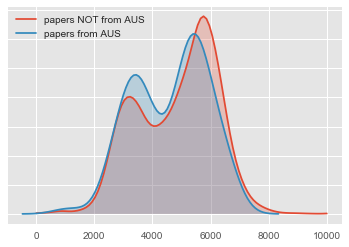

In [11]:
# how big are the papers?
fig, ax = plt.subplots()
sns.kdeplot(df_paper.loc[df_paper.country_paper != 1,'paper_length'], shade=True, ax = ax, clip=(0,10000))
sns.kdeplot(df_paper.loc[df_paper.country_paper == 1,'paper_length'], shade=True, ax = ax)
ax.legend(labels=['papers NOT from AUS','papers from AUS'], loc = 'best')
ax.yaxis.set_ticklabels([])

A lot of papers are either 3K or 5.5K words...The density distribution in Australia and elsewhere is surprising. Is this one of nips requirements?

## Lets impute university affiliations

In [12]:
# create a list of unis that you want to one-hot encode. When you refactor this, it can be a user input
list_of_unis = ['NICTA','Data61','CSIRO','Australian National University','University of Sydney',
                'Deakin University','University of Technology Sydney',
                'University of Queensland','Curtin University of Technology','University of Adelaide',
                'UNSW','University of Melbourne','University of Newcastle']

In [19]:
for uni in list_of_unis:
    if uni=='University of Sydney':
        alternate_words = "|Univ. of Sydney"
    elif uni=='UNSW':
        alternate_words = "|University of New South Wales"
    elif uni=='University of Sydney':
        alternate_words = "|Sydney University"
    elif uni=='NICTA':
        alternate_words = "|National ICT Australia"
        
    df_ozi[uni] = df_ozi.paper_text_500_words.str.upper().str.contains((uni+alternate_words).upper())

## Test

In [32]:
df_ozi[(df_ozi.year>2010) & (df_ozi['UNSW']==True)].sort_values(['year'],ascending=[False])

,paper_text,pdf_name,title,year,paper_length,paper_text_500_words,name,NICTA,Data61,CSIRO,Australian National University,University of Sydney,Deakin University,University of Technology Sydney,University of Queensland,Curtin University of Technology,University of Adelaide,UNSW,University of Melbourne,University of Newcastle
16145,Infinite Hidden Semi-Markov Modulated Interact...,6243-infinite-hidden-semi-markov-modulated-int...,Infinite Hidden Semi-Markov Modulated Interact...,2016,5639,Infinite Hidden Semi-Markov Modulated Interact...,Fang Chen,False,True,True,False,False,False,False,False,False,False,True,True,True
16144,Infinite Hidden Semi-Markov Modulated Interact...,6243-infinite-hidden-semi-markov-modulated-int...,Infinite Hidden Semi-Markov Modulated Interact...,2016,5639,Infinite Hidden Semi-Markov Modulated Interact...,Ting Guo,False,True,True,False,False,False,False,False,False,False,True,True,True
16143,Infinite Hidden Semi-Markov Modulated Interact...,6243-infinite-hidden-semi-markov-modulated-int...,Infinite Hidden Semi-Markov Modulated Interact...,2016,5639,Infinite Hidden Semi-Markov Modulated Interact...,Peng Lin,False,True,True,False,False,False,False,False,False,False,True,True,True
16142,Infinite Hidden Semi-Markov Modulated Interact...,6243-infinite-hidden-semi-markov-modulated-int...,Infinite Hidden Semi-Markov Modulated Interact...,2016,5639,Infinite Hidden Semi-Markov Modulated Interact...,Peng Lin,False,True,True,False,False,False,False,False,False,False,True,True,True
16141,Infinite Hidden Semi-Markov Modulated Interact...,6243-infinite-hidden-semi-markov-modulated-int...,Infinite Hidden Semi-Markov Modulated Interact...,2016,5639,Infinite Hidden Semi-Markov Modulated Interact...,matt zhang,False,True,True,False,False,False,False,False,False,False,True,True,True
16140,Infinite Hidden Semi-Markov Modulated Interact...,6243-infinite-hidden-semi-markov-modulated-int...,Infinite Hidden Semi-Markov Modulated Interact...,2016,5639,Infinite Hidden Semi-Markov Modulated Interact...,Yang Wang,False,True,True,False,False,False,False,False,False,False,True,True,True
16139,Infinite Hidden Semi-Markov Modulated Interact...,6243-infinite-hidden-semi-markov-modulated-int...,Infinite Hidden Semi-Markov Modulated Interact...,2016,5639,Infinite Hidden Semi-Markov Modulated Interact...,Yang Wang,False,True,True,False,False,False,False,False,False,False,True,True,True
13368,"(Almost) No Label No Cry\n\nGiorgio Patrini1,2...",5453-almost-no-label-no-cry.pdf,(Almost) No Label No Cry,2014,6630,"(Almost) No Label No Cry Giorgio Patrini1,2 , ...",Tiberio Caetano,True,False,False,True,False,False,False,False,False,False,True,True,True
13369,"(Almost) No Label No Cry\n\nGiorgio Patrini1,2...",5453-almost-no-label-no-cry.pdf,(Almost) No Label No Cry,2014,6630,"(Almost) No Label No Cry Giorgio Patrini1,2 , ...",Paul Rivera,True,False,False,True,False,False,False,False,False,False,True,True,True
13367,"(Almost) No Label No Cry\n\nGiorgio Patrini1,2...",5453-almost-no-label-no-cry.pdf,(Almost) No Label No Cry,2014,6630,"(Almost) No Label No Cry Giorgio Patrini1,2 , ...",Giorgio Patrini,True,False,False,True,False,False,False,False,False,False,True,True,True


In [ ]:
# a few names of authors since 2010
print ('{} authors for analysis'.format(df_ozi.loc[df_ozi.year > 2010,'name'].value_counts().shape[0]))
df_ozi.loc[df_ozi.year > 2010,'name'].value_counts().head(20)       

In [ ]:
# SO WHO PUBLISHED THIS YEAR?
df_ozi[df_ozi.year == 2017].groupby(by=['name','year']).count()['title'].sort_values(ascending = False)